In [62]:
!pip install --user --quiet pomegranate

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
!git clone https://github.com/pgmpy/pgmpy 

Cloning into 'pgmpy'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 13327 (delta 24), reused 43 (delta 15), pack-reused 13248
Receiving objects: 100% (13327/13327), 6.44 MiB | 0 bytes/s, done.
Resolving deltas: 100% (9286/9286), done.


In [66]:
!cd pgmpy
!python setup.py install --user

running install
running bdist_egg
running egg_info
creating misc_research.egg-info
writing misc_research.egg-info/PKG-INFO
writing dependency_links to misc_research.egg-info/dependency_links.txt
writing top-level names to misc_research.egg-info/top_level.txt
writing manifest file 'misc_research.egg-info/SOURCES.txt'
reading manifest file 'misc_research.egg-info/SOURCES.txt'
writing manifest file 'misc_research.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/zipline_install
copying zipline_install/__init__.py -> build/lib/zipline_install
copying zipline_install/extension.py -> build/lib/zipline_install
copying zipline_install/fetch_local_csv.py -> build/lib/zipline_install
copying zipline_install/futures.py -> build/lib/zipline_install
copying zipline_install/strat.py -> build/lib/zipline_install
copying zipline_install/strat_cf.py -> build/lib/zipline_install
copying 

In [90]:
from graphviz import Source
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

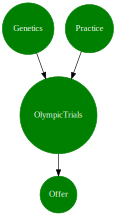

In [60]:
Source(
    """
    digraph {
        node [fontcolor=white shape=circle style=filled color=green]
        size ="3,3";
        Genetics -> OlympicTrials
        Practice -> OlympicTrials
        OlympicTrials -> Offer
    }
    """
)

- joint probability -- fully describe how two or more variables are distibuted simultaneously; P(A=a and B=b)
- conditional -- how prob of A are distrib given a certain value for, say, B: P(A=a | B=b)
- marginal -- averaging over one variable to get the prob distribution of the other; the marginal prob dist of A when A and B are related would be given by $P(a)=\int_B P(a|b)P(b)db$

Bayes Nwtwork is a DAG.
- compact representation of the joint distribution
- observe conditional independence relationships between vertices/random variables

For each node
- you need the distribution in terms of its parent
- if no parent, then the absolute

In [57]:
genes = {'good': 0.2, 'bad': 0.8}
practice = {'yes': 0.7, 'no': 0.3}

# conditional, enumerate all posibilities
# first column is for genes, second for practice
# dict is the resulting prob distribution at the trial
olympic_trials = [
    ['good', 'yes', {'bad': 0.5, 'borderline': 0.3, 'amazing':0.2}],
    ['good', 'no', {'bad': 0.8, 'borderline': 0.15, 'amazing':0.05}],
    ['bad', 'yes', {'bad': 0.8, 'borderline': 0.1, 'amazing':0.1}],
    ['bad', 'no', {'bad': 0.9, 'borderline': 0.08, 'amazing': 0.02}]
]

offer = [
    ['bad', {'no_offer': 0.95, 'offer': 0.05}],
    ['borderline', {'no_offer': 0.8, 'offer': 0.2}],
    ['amazing', {'no_offer': 0.5, 'offer': 0.5}]
]

- each node as a CPD (Conditional Prob Distribution) associated with it
- if the node has parents, the associated CPD represents P(value|parent's value)
- if a node has no parents, the CPD is just P(value), the unconditional prob of that value

In [120]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

Set up the structure with the flows mapped as pairs (from, to)

In [121]:
olympic_model = BayesianModel([
    ('Genetics', 'OlympicTrials'),
    ('Practice', 'OlympicTrials'),
    ('OlympicTrials', 'Offer')
])

Set up the CPDs

In [122]:
genetics_cpd = TabularCPD(
    variable = 'Genetics',
    variable_card = 2,   # cardinality
    values = [[.2, .8]]
)

In [123]:
practice_cpd = TabularCPD(
    variable = 'Practice',
    variable_card = 2,
    values = [[.7, .3]]
)

In [124]:
offer_cpd = TabularCPD(
    variable = 'Offer',
    variable_card = 2,
    values = [[0.95, 0.8, 0.5],
              [.05, .2, .5]],
    evidence = ['OlympicTrials'],
    evidence_card = [3]
)

In [125]:
olympic_trials_cpd = TabularCPD(
    variable = 'OlympicTrials',
    variable_card = 3,
    values = [[.5, .8, .8, .9],
              [.3, .15, .1, .08],
              [.2, .05, .1, .02]],
    evidence = ['Genetics', 'Practice'],
    evidence_card = [2,2]
)

In [77]:
olympic_model.add_cpds(genetics_cpd, practice_cpd, offer_cpd, olympic_trials_cpd)

In [79]:
olympic_model.get_cpds()

[<TabularCPD representing P(Genetics:2) at 0x7f48f9eff2e8>,
 <TabularCPD representing P(Practice:2) at 0x7f48f9eff390>,
 <TabularCPD representing P(Offer:2 | OlympicTrials:3) at 0x7f48f9f2e978>,
 <TabularCPD representing P(OlympicTrials:3 | Genetics:2, Practice:2) at 0x7f48f9f2ec50>]

In [82]:
# what does Genetics influence
olympic_model.active_trail_nodes('Genetics')

{'Genetics': {'Genetics', 'Offer', 'OlympicTrials'}}

In [83]:
# what is independent?
olympic_model.local_independencies('Genetics')

(Genetics _|_ OlympicTrials, Offer, Practice)

In [84]:
olympic_model.get_independencies()

(Genetics _|_ Practice)
(Genetics _|_ Offer | OlympicTrials)
(Genetics _|_ Offer | Practice, OlympicTrials)
(Practice _|_ Genetics)
(Practice _|_ Offer | OlympicTrials)
(Practice _|_ Offer | Genetics, OlympicTrials)
(Offer _|_ Genetics, Practice | OlympicTrials)
(Offer _|_ Practice | Genetics, OlympicTrials)
(Offer _|_ Genetics | Practice, OlympicTrials)

Inference!

In [85]:
from pgmpy.inference import VariableElimination

In [88]:
olympic_infer = VariableElimination(olympic_model)

In [94]:
# If you knew nothing, what's the probabilty of an offer?
prob_offer = olympic_infer.query(variables = ['Offer'])
print(prob_offer['Offer'])

+---------+--------------+
| Offer   |   phi(Offer) |
+=========+==============+
| Offer_0 |       0.8898 |
+---------+--------------+
| Offer_1 |       0.1102 |
+---------+--------------+


In [105]:
prob_offer_bad_genes = olympic_infer.query(
    variables = ['Offer', 'Practice'],   # <-- what to calculate for output
    evidence = {'Genetics':1})           # <-- what you know; 1 means the index of the outcome [0,1]
print(prob_offer_bad_genes['Offer'])
print(prob_offer_bad_genes['Practice'])

+---------+--------------+
| Offer   |   phi(Offer) |
+=========+==============+
| Offer_0 |       0.9017 |
+---------+--------------+
| Offer_1 |       0.0983 |
+---------+--------------+
+------------+-----------------+
| Practice   |   phi(Practice) |
+============+=================+
| Practice_0 |          0.7000 |
+------------+-----------------+
| Practice_1 |          0.3000 |
+------------+-----------------+


**The real power: go upstream!**

In [107]:
prob_good_genes_if_amazing_olympic_trials = olympic_infer.query(
    variables = ['Genetics'],
    evidence = {'OlympicTrials': 2}   # <-- 2 means the index of the outcome [0,1,2], so "amazing"
)
print(prob_good_genes_if_amazing_olympic_trials['Genetics'])

+------------+-----------------+
| Genetics   |   phi(Genetics) |
+============+=================+
| Genetics_0 |          0.3377 |
+------------+-----------------+
| Genetics_1 |          0.6623 |
+------------+-----------------+


In [109]:
prob_good_genes_if_no_practice_good_olympic_trials = olympic_infer.query(
    variables = ['Genetics'],
    evidence = {'Practice': 1, 'OlympicTrials': 2}
)
print(prob_good_genes_if_no_practice_good_olympic_trials['Genetics'])

+------------+-----------------+
| Genetics   |   phi(Genetics) |
+============+=================+
| Genetics_0 |          0.3846 |
+------------+-----------------+
| Genetics_1 |          0.6154 |
+------------+-----------------+


What's the most probable state for a variable?

In [111]:
olympic_infer.map_query(variables = ['Genetics', 'Offer', 'OlympicTrials'])

{'Genetics': 1, 'Offer': 0, 'OlympicTrials': 0}

Let's try for a continuous variable.

In [130]:
from pgmpy.factors.continuous import ContinuousFactor

In [133]:
from scipy.stats import norm
from pgmpy.factors.distributions import GaussianDistribution

In [134]:
?GaussianDistribution

In [131]:
?ContinuousFactor

In [126]:
genetics_c_cpd = LinearGaussianCPD(
    variable = 'Genetics_C',
    evidence_mean = 500,
    evidence_variance = 50
)

In [127]:
olympic_model_c = BayesianModel([
    ('Genetics_C', 'OlympicTrials'),
    ('Practice', 'OlympicTrials'),
    ('OlympicTrials', 'Offer')
])

In [129]:
olympic_model_C.add_cpds(genetics_c_cpd, practice_cpd, offer_cpd, olympic_trials_cpd)

ValueError: Only TabularCPD or ContinuousFactor can be added.

# pomegranate

In [135]:

from pomegranate import (
    BayesianNetwork,
    ConditionalProbabilityTable,
    DiscreteDistribution,
    State
)

In [138]:
?ConditionalProbabilityTable

https://www.youtube.com/watch?v=KpoNWIiH2ic

- an arrow means conditionally dependent
- direction matters
- if there is no edge, then it represents conditional independence
- intepretable!
- Two tasks
    - inference given incomplete information (uses Belief Propagation)
    - learning dependency structure
    
- User needs to define model and structure
- Then can set various nodes and see *all* the other nodes
- Is this just boolean at each node???

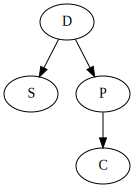

In [50]:
Source(
    """
    digraph {
        size ="3,3";
        D -> S
        D -> P
        P -> C
    }
    """
)

In [32]:
day_of_week = DiscreteDistribution(
    {'weekday': 5./7, 'weekend': 2./7}
)

sunny = DiscreteDistribution(
    {'weekday': 0.80, 'weekend': 0.60}
)


In [33]:
who = ConditionalProbabilityTable([
    ['weekday', 'Alice', 0.90],
    ['weekend', 'Alice', 0.1],
    ['weekday', 'Bob', 0.35],
    ['weekend', 'Bob', 0.65],
    ['weekday', 'Claire', 0.5],
    ['weekend', 'Claire', 0.50]
], [day_of_week])

In [ ]:
correct = DiscreteDistribution(
    {'Alice': 0.8, 'Bob': 0.55, 'Claire': 0.65}
)

In [35]:
s1 = State(day_of_week, name="day_of_week")
s2 = State(who, name="who")
s3 = State(sunny, name="sunny")
s4 = State(correct, name="correct")

In [38]:
network = BayesianNetwork("Weather: day of week")
network.add_states(s1, s2, s3, s4)
network.add_transition(s1, s2)
network.add_transition(s1, s3)
network.add_transition(s2, s4)

In [39]:
network.bake()

In [49]:
network.predict_proba({'who': 'Bob'})

array([{
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "weekday" :0.6422018348623852,
            "weekend" :0.35779816513761475
        }
    ],
    "frozen" :false
},
       'Bob',
       {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "weekday" :0.5714285714285714,
            "weekend" :0.42857142857142855
        }
    ],
    "frozen" :false
},
       {
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "Alice" :0.39999999999999997,
            "Bob" :0.275,
            "Claire" :0.32499999999999996
        }
    ],
    "frozen" :false
}], dtype=object)